# 代码复现

## 工业蒸汽数据代码复现
- 数据的导入， 工具包导入
- 数据挖掘目的分析
- 数据探索（数据分布、相关性）
- 数据预处理（归一化），数据降维
- 模型训练、交叉验证、参数调优，模型融合（投票）

## 数据准备

In [2]:
import numpy as np
import pandas as pd

train_data_path = r'E:/DataSet/Tianchi/zhengqi/zhengqi_train.txt'
test_data_path = r'E:/DataSet/Tianchi/zhengqi/zhengqi_test.txt'

train_data = pd.read_csv(train_data_path, sep='\t', encoding='utf-8')
test_data = pd.read_csv(test_data_path, sep='\t', encoding='utf-8')

In [4]:
# train_data.describe()
# target是连续性的数值，需要用到回归模型
# 总计38个特征，特征值的取值区间不一致，需要做归一化处理
# V9的特征粗看无差异，相关性应该较差，需要进一步验证
train_data.head(10)

V0     V1     V2     V3     V4     V5     V6     V7     V8     V9  ...  \
0  0.566  0.016 -0.143  0.407  0.452 -0.901 -1.812 -2.360 -0.436 -2.114  ...   
1  0.968  0.437  0.066  0.566  0.194 -0.893 -1.566 -2.360  0.332 -2.114  ...   
2  1.013  0.568  0.235  0.370  0.112 -0.797 -1.367 -2.360  0.396 -2.114  ...   
3  0.733  0.368  0.283  0.165  0.599 -0.679 -1.200 -2.086  0.403 -2.114  ...   
4  0.684  0.638  0.260  0.209  0.337 -0.454 -1.073 -2.086  0.314 -2.114  ...   
5  0.445  0.627  0.408  0.220  0.458 -1.056 -1.009 -1.896  0.481 -2.114  ...   
6  0.889  0.416  0.640  0.356  0.224 -0.893 -0.812 -1.823  0.729 -2.114  ...   
7  0.984  0.529  0.704  0.438  0.258 -0.917 -0.682 -1.721  0.753 -2.114  ...   
8  0.948  0.850  0.584  0.459  0.591 -0.523 -0.591 -1.524  0.763 -2.114  ...   
9  1.157  1.055  0.638  0.617  1.483 -0.731 -0.612 -1.524  0.968 -2.114  ...   

     V29    V30    V31    V32    V33    V34    V35    V36    V37  target  
0  0.136  0.109 -0.615  0.327 -4.627 -4.789 -5.101 -2.608 -3.508   0.175  
1 -0.128  0.124  0.032  0.600 -0.843  0.160  0.364 -0.335 -0.730   0.676  
2 -0.009  0.361  0.277 -0.116 -0.843  0.160  0.364  0.765 -0.589   0.633  
3  0.015  0.417  0.279  0.603 -0.843 -0.065  0.364  0.333 -0.112   0.206  
4  0.183  1.078  0.328  0.418 -0.843 -0.215  0.364 -0.280 -0.028   0.384  
5  0.454  0.674  0.358  0.618 -0.843 -0.290  0.364 -0.191 -0.883   0.060  
6  0.454  0.081  0.243  0.468 -0.843 -0.290  0.364 -0.155 -1.318   0.415  
7  0.139 -0.050  0.428 -0.119 -0.843 -0.290  0.364  0.100 -0.899   0.609  
8  0.188  0.467  0.597 -0.057 -0.843 -0.290  0.364  0.053 -0.553   0.981  
9  0.860  0.456  0.916  0.039 -0.843 -0.290  0.364  0.151 -1.157   0.818  

[10 rows x 39 columns]

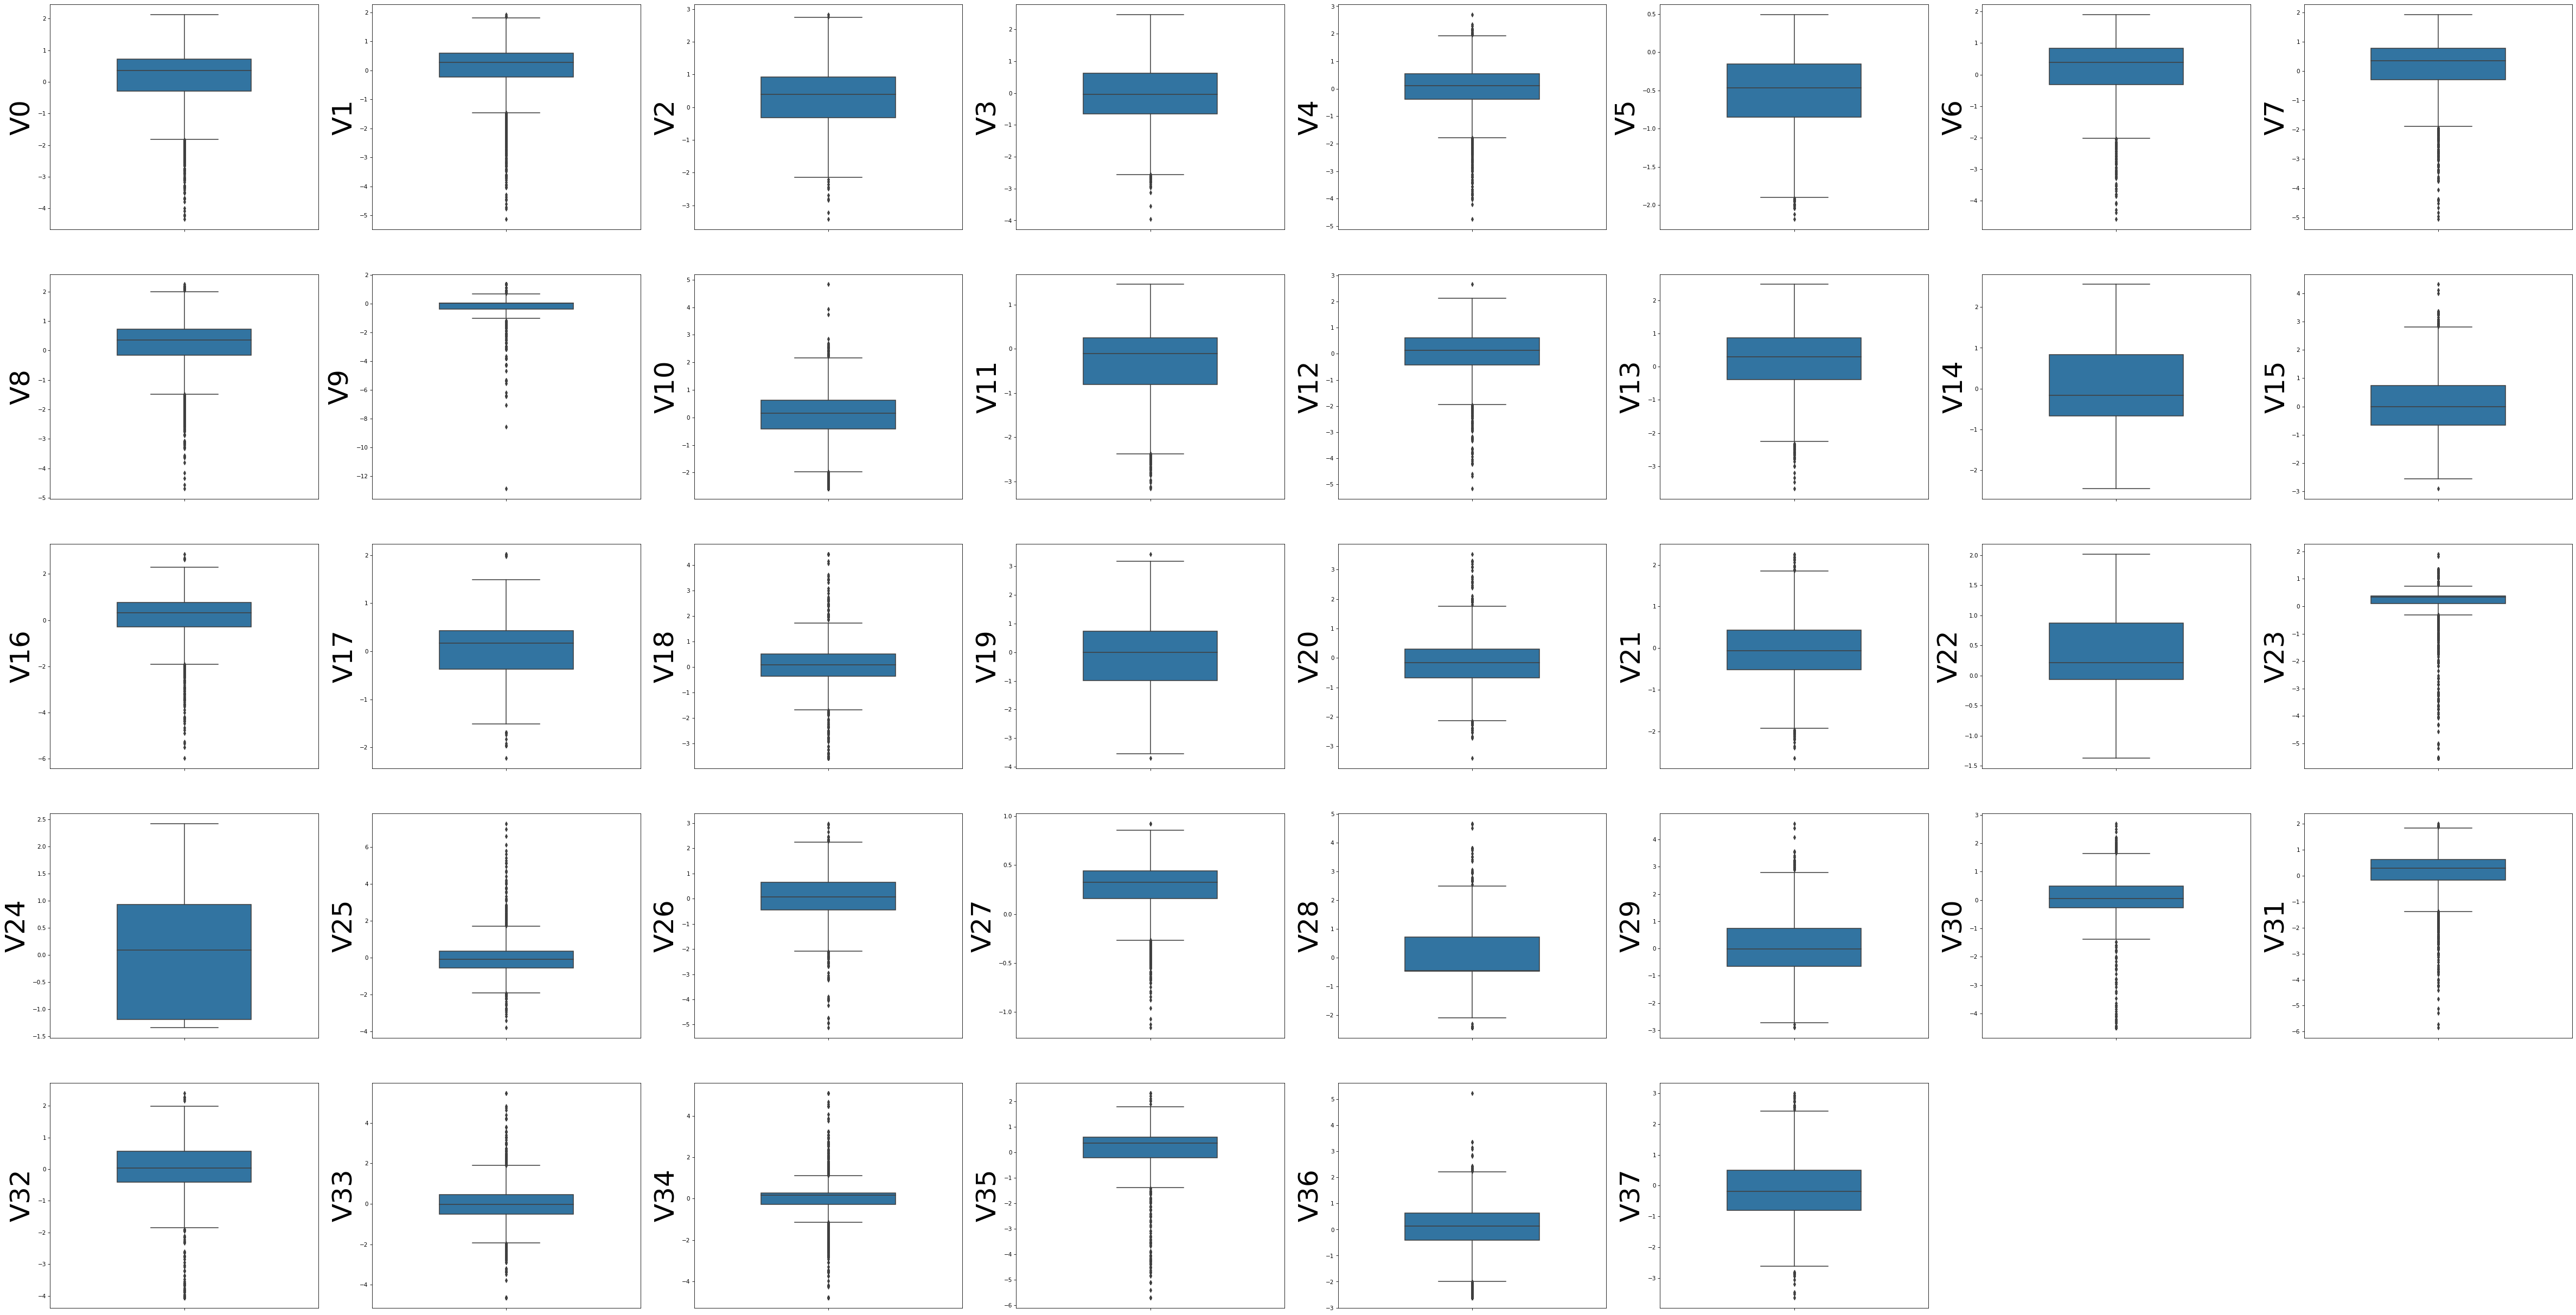

In [23]:
# 数据探索阶段
# 单个特征的分布情况（箱线图）可视化
import warnings
warnings.filterwarnings('ignore')
import seaborn  as sns
import matplotlib.pyplot as plt
%matplotlib inline
feature_columns = [col for col in train_data.columns if col not in ['target']]

fig = plt.figure(figsize=(80, 60), dpi=75)
for idx, col_name in enumerate(feature_columns):
    plt.subplot(7, 8, idx+1)
    sns.boxplot(x=train_data[col_name], orient='v', width=0.5)
    plt.ylabel(col_name, fontsize=48)
plt.show()
# V1, V7, V9, V16, V23, V30, V31, V32, V35等特征的粗存在较多异常值

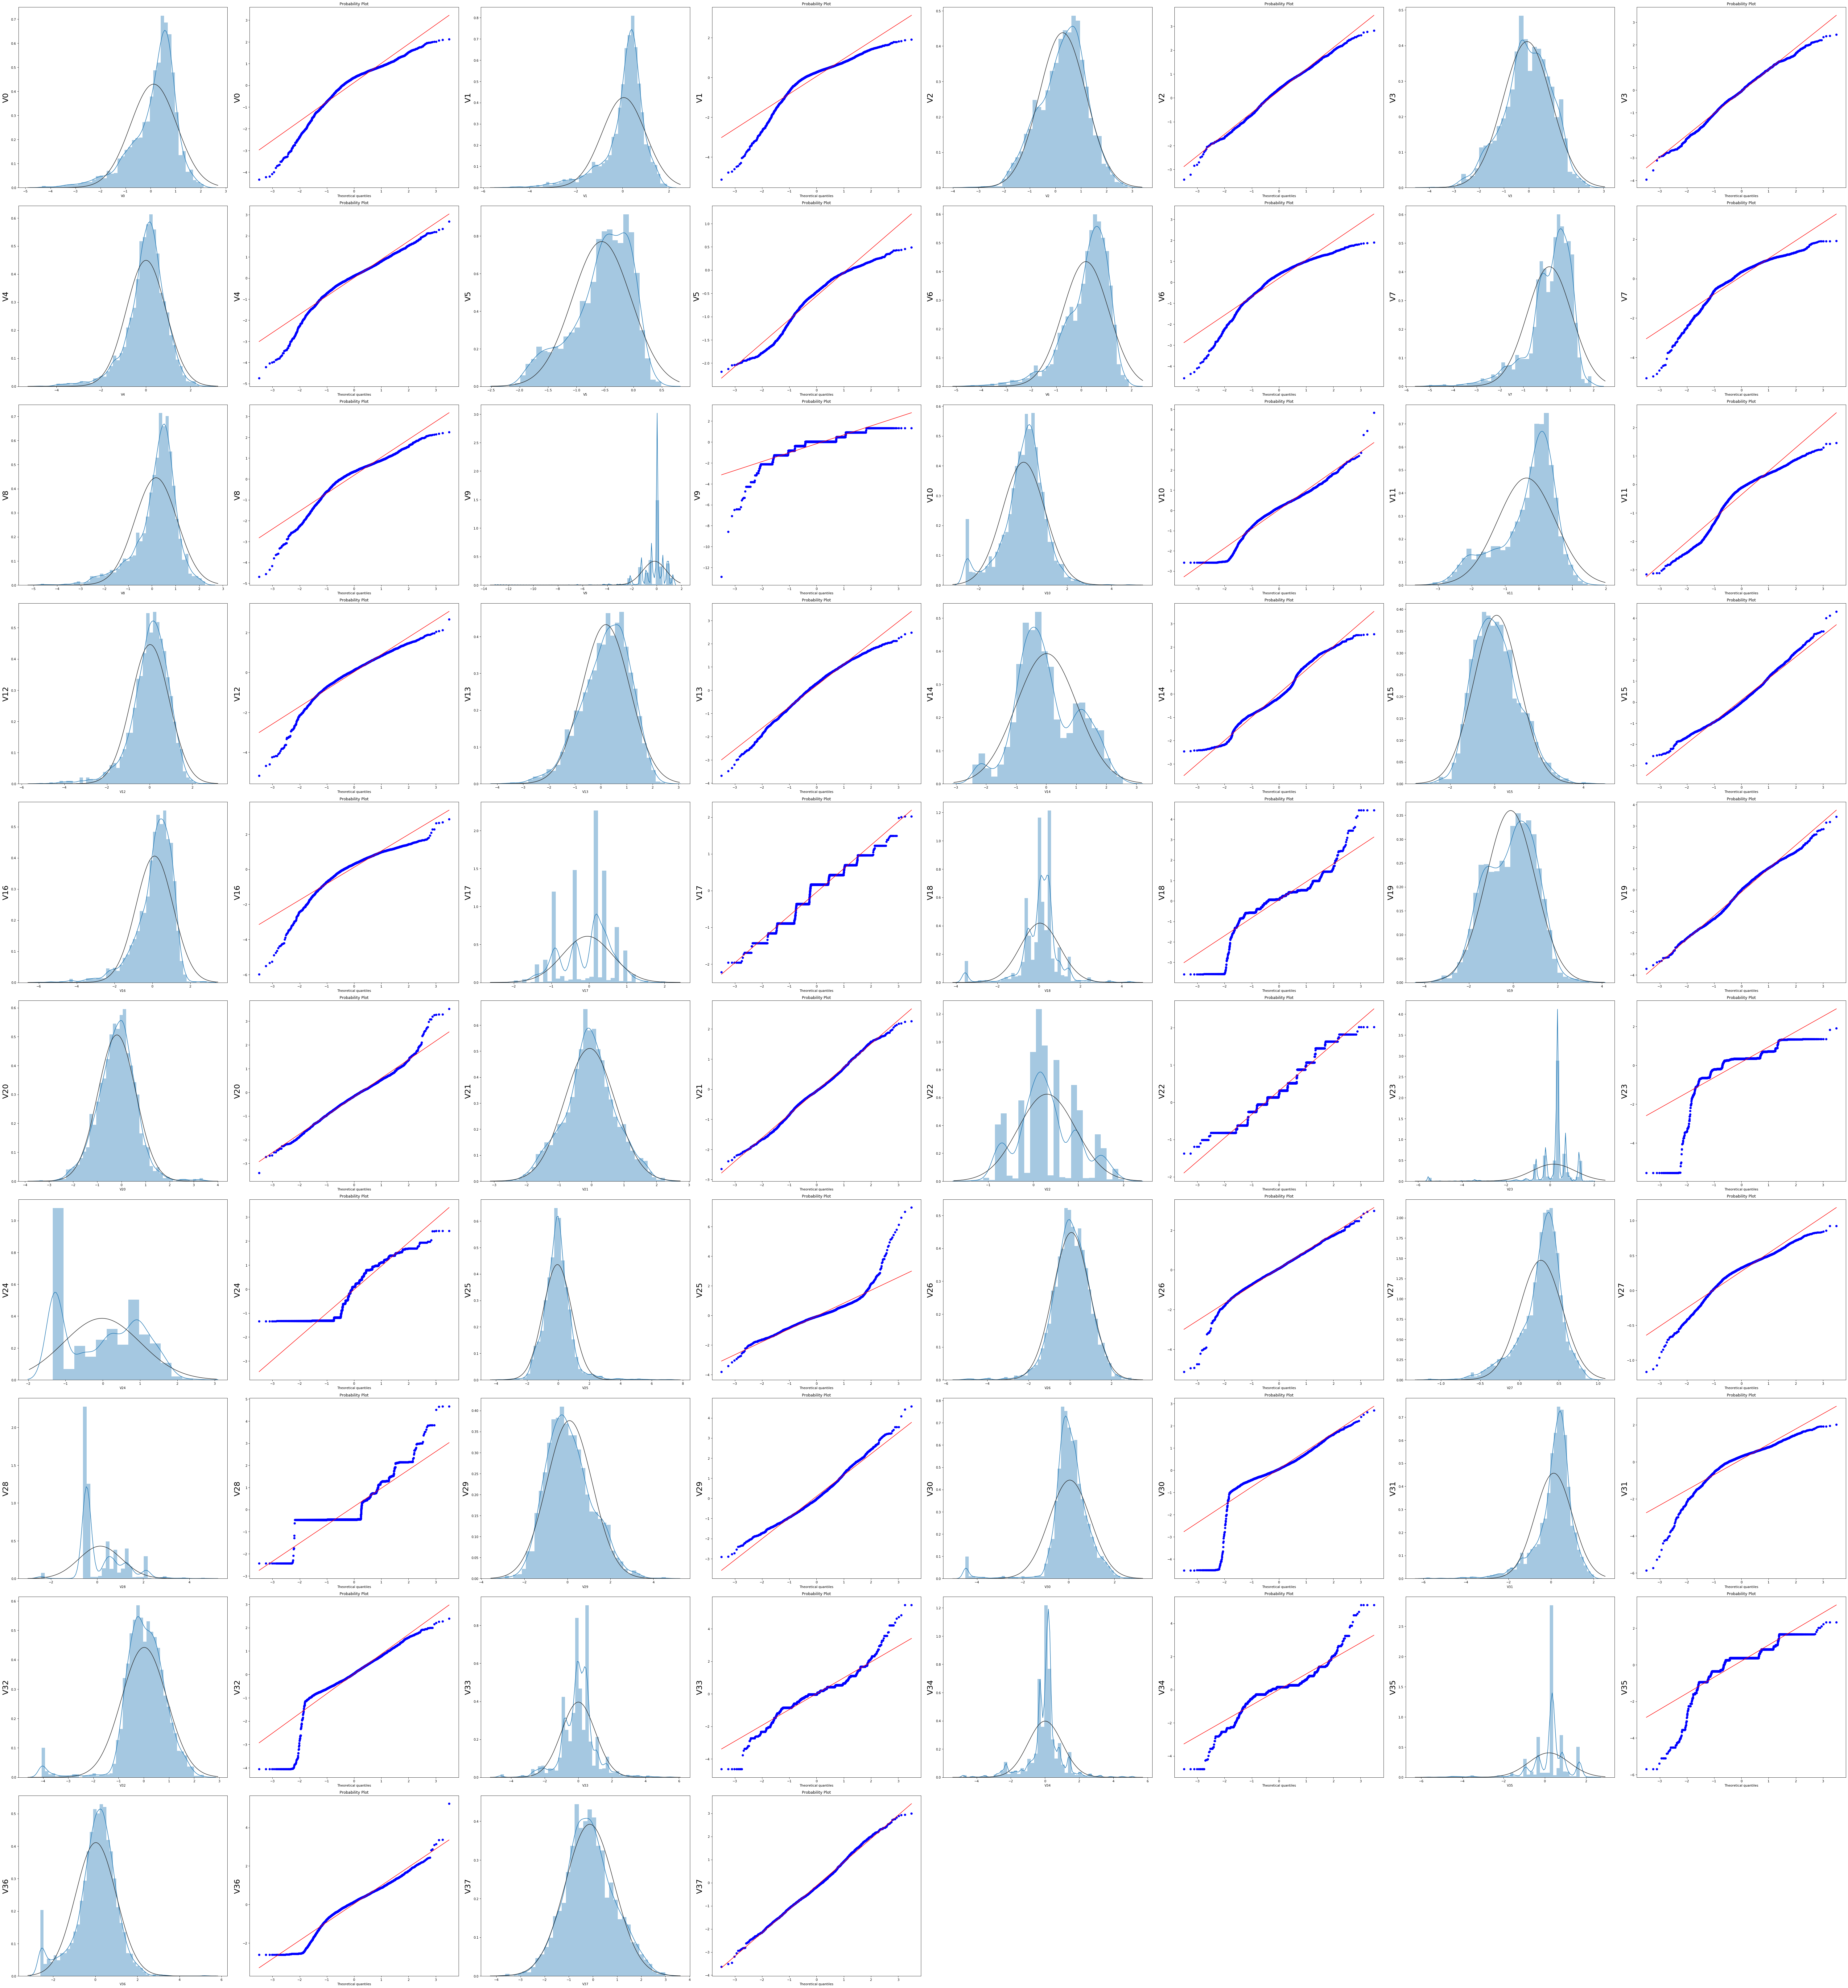

In [31]:
# 探索数据分正太分布情况
from scipy import stats
feature_columns = [col for col in train_data.columns if col not in ['target']]

fig = plt.figure(figsize=(80, 120), dpi=75)
i = 0
for idx, col_name in enumerate(feature_columns):
    i += 1
    ax = plt.subplot(14, 8, i)
    sns.distplot(a=train_data[col_name], fit=stats.norm)
    plt.ylabel(col_name, fontsize=24)
    
    i += 1
    ax = plt.subplot(14, 8, i)
    res = stats.probplot(x=train_data[col_name], plot=plt)
    plt.ylabel(col_name, fontsize=24)
plt.tight_layout()
plt.show()
# 超过一半的特征的不是正太分布，需要做转换

In [37]:
# 探索训练集合测试集的分布差异
from scipy import stats
feature_columns = [col for col in train_data.columns if col not in ['target']]

fig = plt.figure(figsize=(80, 120), dpi=75)
i = 0
for idx, col_name in enumerate(feature_columns):
    ax = plt.subplot(10, 4, idx + 1)
    ax = sns.kdeplot(train_data[col_name], shade=True, color='Red')
    ax = sns.kdeplot(test_data[col_name], shade=True, color='Blue')
    ax.set_xlabel(col_name)
    ax.set_ylabel('Frequency')
    ax = ax.legend(['train', 'test'])
    
plt.show()
# V5, V9, V11, V17, V22, V28 这特征在训练集和测试集上的分布差异较大，应当剔除数据

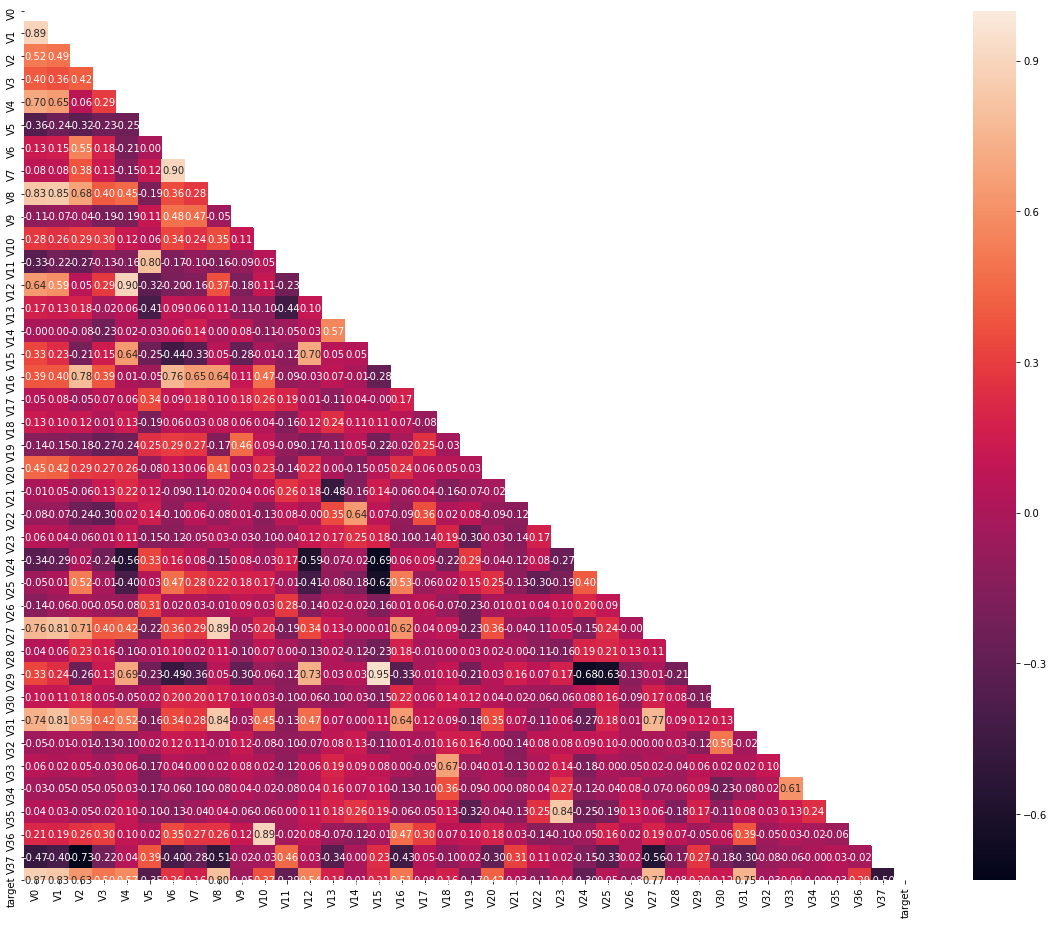

In [56]:
# 相关性探索
train_corr = train_data.corr(method='spearman')
# 相关性转换为绝对值
# train_corr = train_corr.abs()
plt.figure(figsize=(20, 16))
mask = np.zeros_like(train_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
g = sns.heatmap(train_corr, mask=mask, square=True, annot=True, fmt='0.2f')
plt.show()

In [60]:
# 数据预处理
# 数据缩放
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_columns = [col for col in train_data.columns if col not in ['target']]
train_data_scaler = train_data[feature_columns]
test_data_scaler = test_data[feature_columns]

scaler = scaler.fit(train_data_scaler)
train_data_scaler = scaler.transform(train_data_scaler)
test_data_scaler = scaler.transform(test_data_scaler)
train_data_scaler = pd.DataFrame(train_data_scaler)
train_data_scaler.columns = feature_columns
test_data_scaler = pd.DataFrame(test_data_scaler)
test_data_scaler.columns = feature_columns
train_data_scaler['target'] = train_data['target']

display(train_data_scaler.describe())

V0           V1           V2           V3           V4  \
count  2888.000000  2888.000000  2888.000000  2888.000000  2888.000000   
mean      0.690528     0.735521     0.593745     0.606301     0.639876   
std       0.143747     0.133738     0.145844     0.151302     0.119550   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.625465     0.695419     0.497279     0.515165     0.586328   
50%       0.727076     0.766264     0.609155     0.609933     0.652940   
75%       0.783922     0.812642     0.694342     0.714174     0.712185   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

                V5           V6           V7           V8           V9  ...  \
count  2888.000000  2888.000000  2888.000000  2888.000000  2888.000000  ...   
mean      0.607801     0.735418     0.741337     0.702012     0.894246  ...   
std       0.193919     0.141872     0.137111     0.129082     0.067047  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.497566     0.659249     0.682314     0.653453     0.878743  ...   
50%       0.642456     0.767115     0.774045     0.728557     0.909110  ...   
75%       0.759266     0.835613     0.836958     0.781029     0.909110  ...   
max       1.000000     1.000000     1.000000     1.000000     1.000000  ...   

               V29          V30          V31          V32          V33  \
count  2888.000000  2888.000000  2888.000000  2888.000000  2888.000000   
mean      0.401715     0.634030     0.760517     0.631794     0.459255   
std       0.141644     0.125338     0.110903     0.139979     0.099782   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.300053     0.586993     0.722656     0.565408     0.409037   
50%       0.385611     0.633755     0.782330     0.634615     0.454518   
75%       0.488154     0.694136     0.824949     0.714950     0.504261   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               V34          V35          V36          V37       target  
count  2888.000000  2888.000000  2888.000000  2888.000000  2888.000000  
mean      0.484465     0.734850     0.336306     0.527854     0.126353  
std       0.101353     0.122917     0.123733     0.153423     0.983966  
min       0.000000     0.000000     0.000000     0.000000    -3.044000  
25%       0.454490     0.684936     0.279760     0.427112    -0.350250  
50%       0.499949     0.755580     0.349860     0.519532     0.313000  
75%       0.511365     0.785260     0.414511     0.622210     0.793250  
max       1.000000     1.000000     1.000000     1.000000     2.538000  

[8 rows x 39 columns]

In [61]:
# 特征降维
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9)
pca = pca.fit(train_data_scaler.iloc[:, :-1])

train_data_scaler_pca90 = pca.fit_transform(train_data_scaler.iloc[:, :-1])
test_data_scaler_pca90 = pca.transform(test_data_scaler)

train_data_scaler_pca90 = pd.DataFrame(train_data_scaler_pca90)
test_data_scaler_pca90 = pd.DataFrame(test_data_scaler_pca90)
train_data_scaler_pca90['target'] = train_data_scaler['target']
display(train_data_scaler_pca90.describe())

# 总计值剩下16个特征

0             1             2             3             4  \
count  2.888000e+03  2.888000e+03  2.888000e+03  2.888000e+03  2.888000e+03   
mean  -9.841312e-17  4.920656e-18 -1.722230e-17 -6.396853e-17  7.627017e-17   
std    3.985421e-01  3.490520e-01  2.938955e-01  2.722600e-01  2.035064e-01   
min   -1.070204e+00 -9.382404e-01 -1.019585e+00 -6.853347e-01 -7.648509e-01   
25%   -2.802786e-01 -2.603790e-01 -2.062572e-01 -1.971748e-01 -1.250776e-01   
50%   -1.551054e-02 -8.985867e-03 -1.862128e-02 -2.277698e-02 -4.541365e-03   
75%    2.275077e-01  2.322535e-01  2.133431e-01  1.680986e-01  1.236219e-01   
max    1.603357e+00  1.351734e+00  1.021067e+00  1.423139e+00  9.969989e-01   

                  5             6             7             8             9  \
count  2.888000e+03  2.888000e+03  2.888000e+03  2.888000e+03  2.888000e+03   
mean   3.444459e-17 -6.888918e-17 -1.230164e-18 -1.476197e-17  1.230164e-18   
std    1.961281e-01  1.861363e-01  1.607591e-01  1.513411e-01  1.442443e-01   
min   -5.531376e-01 -5.727510e-01 -5.914083e-01 -6.297522e-01 -4.842131e-01   
25%   -1.246339e-01 -1.256336e-01 -1.009689e-01 -9.717828e-02 -9.245411e-02   
50%   -1.473143e-02  1.033570e-04 -5.335135e-03  2.214191e-03 -2.135596e-03   
75%    1.020631e-01  1.271116e-01  9.692888e-02  1.005325e-01  9.123200e-02   
max    1.301563e+00  6.259154e-01  7.454770e-01  6.420087e-01  5.824542e-01   

                 10            11            12            13            14  \
count  2.888000e+03  2.888000e+03  2.888000e+03  2.888000e+03  2.888000e+03   
mean  -1.107148e-17  2.460328e-18 -2.029771e-17  2.275803e-17 -1.722230e-17   
std    1.345876e-01  1.289251e-01  1.181146e-01  1.148697e-01  1.113406e-01   
min   -5.975088e-01 -5.773973e-01 -4.258712e-01 -4.576412e-01 -3.888960e-01   
25%   -8.370005e-02 -7.805577e-02 -7.327538e-02 -7.525674e-02 -7.156570e-02   
50%    5.987825e-03 -5.016301e-03 -7.593646e-03  6.604729e-05 -2.201764e-03   
75%    8.494287e-02  7.162226e-02  6.871951e-02  7.942442e-02  6.896065e-02   
max    6.165259e-01  6.543877e-01  5.559756e-01  5.139705e-01  5.040193e-01   

                 15       target  
count  2.888000e+03  2888.000000  
mean  -5.351213e-17     0.126353  
std    1.018260e-01     0.983966  
min   -3.658579e-01    -3.044000  
25%   -6.565231e-02    -0.350250  
50%   -1.059611e-03     0.313000  
75%    6.298074e-02     0.793250  
max    4.505913e-01     2.538000

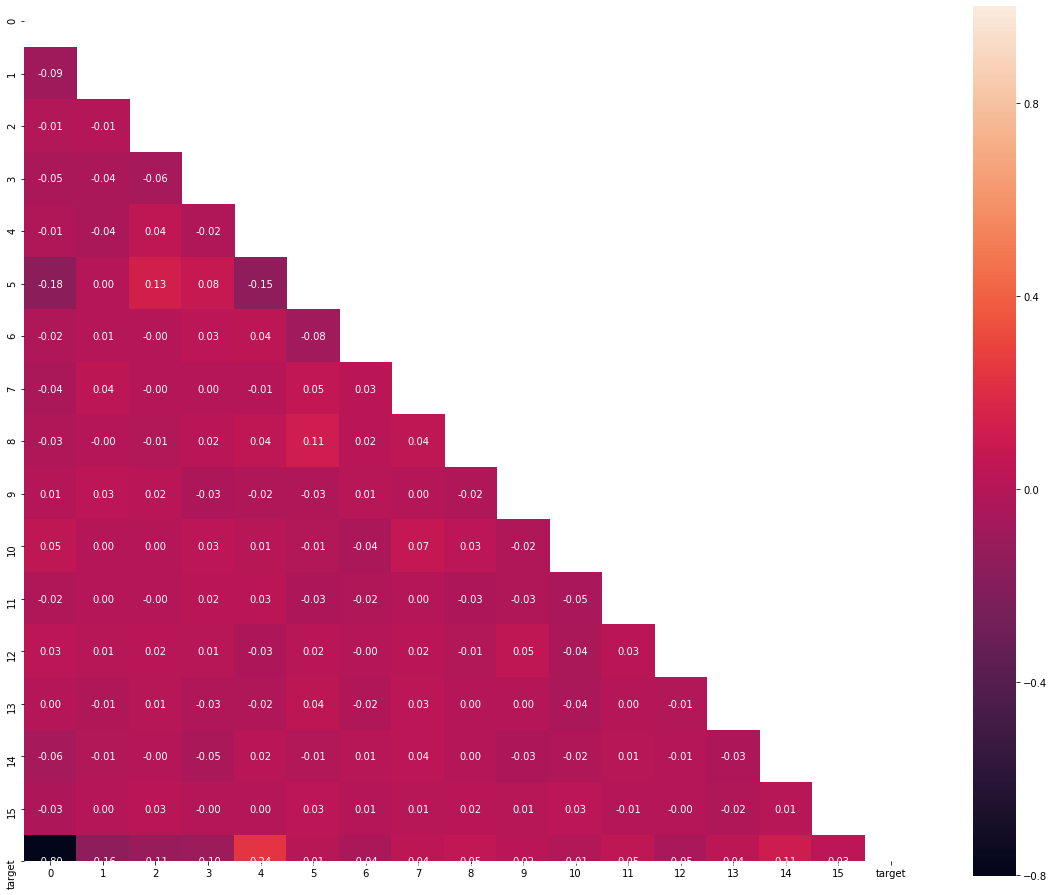

In [62]:
# 相关性剔除
# 重新计算相关性
train_corr = train_data_scaler_pca90.corr(method='spearman')
# 相关性转换为绝对值
# train_corr = train_corr.abs()
plt.figure(figsize=(20, 16))
mask = np.zeros_like(train_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# cmap = sns.diverging_palette(220, 10, as_cmap=True)
g = sns.heatmap(train_corr, mask=mask, square=True, annot=True, fmt='0.2f')
plt.show()

In [63]:
# 模型训练
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import lightgbm as lgb

In [72]:
# 切分数据
train_data_scaler_pca90 = train_data_scaler_pca90.fillna(0)
train = train_data_scaler_pca90[test_data_scaler_pca90.columns]
target = train_data_scaler_pca90['target']
train_data, test_data, train_target, test_target = train_test_split(train,
                                                                    target,
                                                                    test_size=0.2,
                                                                    random_state=2021)

In [78]:
# 线性模型
for pen in ['l1', 'l2', 'elasticnet']:
    clf = SGDRegressor(penalty=pen, tol=1e-3, random_state=2021,max_iter=500)
    clf.fit(train_data, train_target)
    score = mean_squared_error(test_target, clf.predict(test_data))
    print('LogisticRegression with {} mse scores: {}'.format(pen, score))

LogisticRegression with l1 mse scores: 0.13380325930134007
LogisticRegression with l2 mse scores: 0.13367896767825205
LogisticRegression with elasticnet mse scores: 0.13369818463883848


In [86]:
help(lgb.LGBMRegressor)

Help on class LGBMRegressor in module lightgbm.sklearn:

class LGBMRegressor(LGBMModel, sklearn.base.RegressorMixin)
 |  LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True, importance_type='split', **kwargs)
 |  
 |  LightGBM regressor.
 |  
 |  Method resolution order:
 |      LGBMRegressor
 |      LGBMModel
 |      sklearn.base.BaseEstimator
 |      sklearn.base.RegressorMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  fit(self, X, y, sample_weight=None, init_score=None, eval_set=None, eval_names=None, eval_sample_weight=None, eval_init_score=None, eval_metric=None, early_stopping_rounds=None, verbose=True, feature_name='auto', categorical_feature='auto', callbac

In [84]:
# RandomFrest
clf = RandomForestRegressor(n_estimators=500, max_depth=5)
clf.fit(train_data, train_target)
score = mean_squared_error(test_target, clf.predict(test_data))
print('RandomForestRegressor mse scores: {}'.format( score))

RandomForestRegressor  mse scores: 0.19507707050127016


In [94]:
# lightGBM
lgb_reg = lgb.LGBMRegressor(n_estimators=500,
                            learning_rate=0.01,
                            max_depth=-1,
                            boosting_type='gbdt',
                            random_state=2021,
                            objective='regression'
                            )
lgb_reg.fit(X=train_data, y=train_target,
            eval_names=['Train', 'Test'],
            eval_set=[(train_data, train_target), (test_data, test_target)],
            early_stopping_rounds=100,
            eval_metric='MSE',
            verbose=0)
score = mean_squared_error(test_target, lgb_reg.predict(test_data, num_iteration=lgb_reg.best_iteration_))
print('LGBMRegressor mse scores: {}'.format( score))

LGBMRegressor mse scores: 0.1306261181142292
